#### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

### Configurations

In [2]:
M           = 8                 #Number of clients
A           = 10                #loacal epochs
G           = 100               # global rounds
bs          = 64                #bactch size
lr          = 0.01              #learning rate
clip_C      = 1.0               #clipping norm
delta       = 1e-5              #DP Parameter delta
eps_list    = [1, 2, 5, 10]     # privacy budgets ε
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model Defination

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

### IID Split (Independetly and Identically Distributed)

In [4]:
def get_iid_loaders(dataset, M, bs):
    idx = torch.randperm(len(dataset))
    split = len(dataset) // M
    loaders = []

    for i in range(M):
        part = idx[i*split:(i+1)*split]
        sub  = Subset(dataset, part)
        loader = DataLoader(sub, batch_size = bs , shuffle = True)
        loaders.append(loader)
    return loaders


### DP Clip && Noise

In [5]:
def dp_clip_and_noise(client_model, global_model, epsilon, delta, clip_C, G, D_tau_min):
    """
    Apply per-layer clipping and DP noise based on dynamic D_min.
    """
    sensitivity = (2 * clip_C) / D_tau_min
    sigma = (sensitivity * np.sqrt(2 * G * np.log(1.25 / delta))) / epsilon

    g_state = global_model.state_dict()
    c_state = client_model.state_dict()
    new_state = {}

    for k in g_state:
        delta_w = c_state[k].to(device) - g_state[k].to(device)
        norm = torch.norm(delta_w)

        if norm > clip_C:
            delta_w = delta_w * (clip_C / norm)

        noise = torch.randn_like(delta_w) * sigma
        new_state[k] = g_state[k].to(device) + delta_w + noise

    return new_state


### Server Aggregation 

In [6]:
def server_aggregate(states):
    """Averages a list of state_dicts."""
    agg = {}
    for k in states[0]:
        agg[k] = sum([st[k] for st in states]) / len(states)
    return agg


### TRAIN & EVAL LOOPS 

In [7]:
def local_train(model, loader, global_state):
    """Train model starting from global_state for A epochs."""
    model.load_state_dict(global_state)
    opt = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for _ in range(A):
        for x,y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss_fn(logits, y).backward()
            opt.step()

def evaluate(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x,y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            total_loss += loss_fn(logits, y).item()
            _,pred = logits.max(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    return total_loss/total, correct/total

### Main Experiment

In [ ]:

# Load MNIST

transform = transforms.ToTensor()
train_ds  = datasets.MNIST('.',train=True,download=True,transform=transform)
test_ds   = datasets.MNIST('.',train=False,download=True,transform=transform)
test_loader = DataLoader(test_ds,batch_size=bs, shuffle=False)


# IID Split
client_loaders = get_iid_loaders(train_ds, M, bs)

results = {}  # store metrics for each epsilon


for eps in eps_list:
    print(f"\n=== Running ε = {eps} ===")
    # initialize global model
    global_model = SimpleMLP().to(device)
    global_state = global_model.state_dict()

    loss_hist, acc_hist = [], []

    for rnd in range(1, G+1):
        # local training + DP updates
        dp_states = []
        for loader in client_loaders:
            local_model = SimpleMLP().to(device)
            local_train(local_model, loader, global_state)
            D_tau_min = min([len(loader.dataset) for loader in client_loaders])
            dp_state = dp_clip_and_noise(local_model, global_model,eps, delta, clip_C, G , D_tau_min )
            dp_states.append(dp_state)

        # aggregate
        agg_state = server_aggregate(dp_states)
        global_state = agg_state
        global_model.load_state_dict(global_state)

        # evaluation
        loss, acc = evaluate(global_model, test_loader)
        loss_hist.append(loss)
        acc_hist.append(acc)

        if rnd % 20 == 0:
            print(f" Round {rnd:3d}  Loss {loss:.4f}  Acc {acc:.3f}")

    results[eps] = (loss_hist, acc_hist)
    


=== Running ε = 1 ===
 Round  20  Loss 0.1928  Acc 0.942
 Round  40  Loss 0.1426  Acc 0.957
 Round  60  Loss 0.1227  Acc 0.964
 Round  80  Loss 0.1142  Acc 0.965
 Round 100  Loss 0.1080  Acc 0.967

=== Running ε = 2 ===
 Round  20  Loss 0.1953  Acc 0.945
 Round  40  Loss 0.1452  Acc 0.958
 Round  60  Loss 0.1238  Acc 0.964
 Round  80  Loss 0.1116  Acc 0.967
 Round 100  Loss 0.1053  Acc 0.968

=== Running ε = 5 ===
 Round  20  Loss 0.1960  Acc 0.943
 Round  40  Loss 0.1407  Acc 0.958
 Round  60  Loss 0.1202  Acc 0.964
 Round  80  Loss 0.1100  Acc 0.967
 Round 100  Loss 0.1049  Acc 0.968

=== Running ε = 10 ===
 Round  20  Loss 0.1877  Acc 0.946
 Round  40  Loss 0.1345  Acc 0.960
 Round  60  Loss 0.1151  Acc 0.964
 Round  80  Loss 0.1062  Acc 0.968
 Round 100  Loss 0.1009  Acc 0.970


Plot

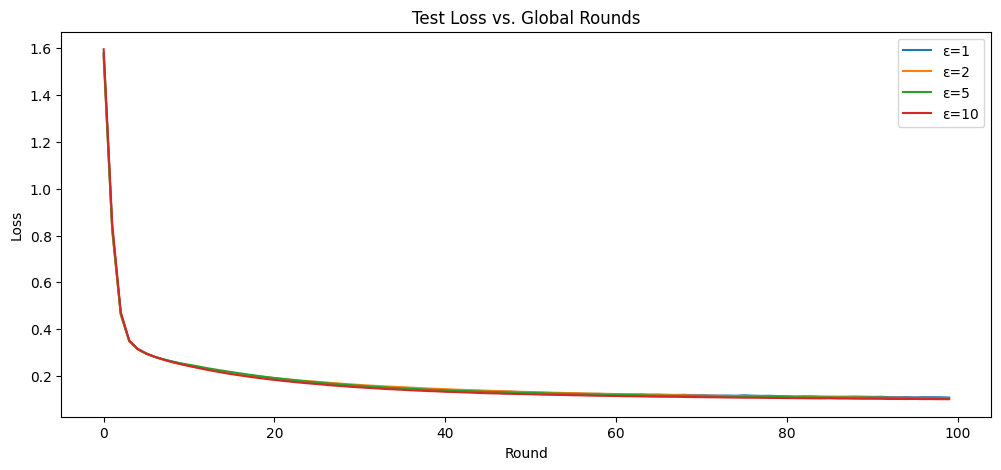

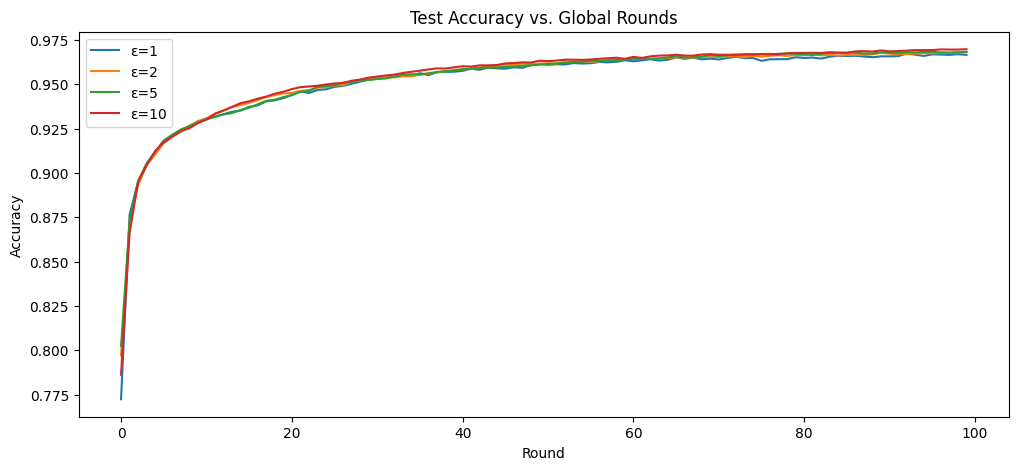

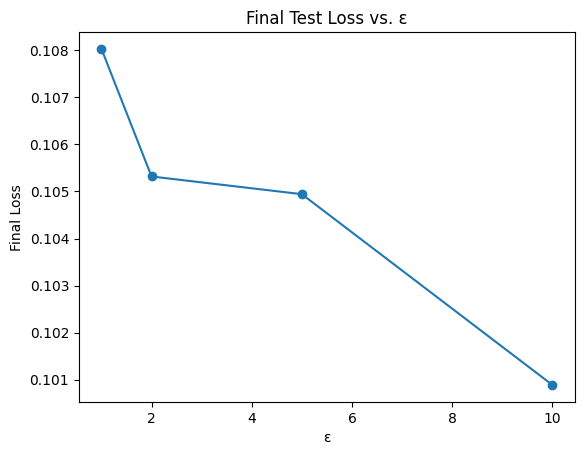

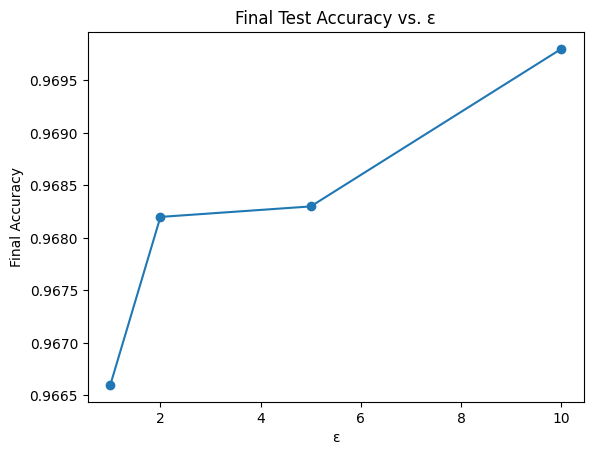

In [11]:
plt.figure(figsize=(12,5))
for eps,(l,a) in results.items():
    plt.plot(l, label=f"ε={eps}")
plt.title("Test Loss vs. Global Rounds")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for eps,(l,a) in results.items():
    plt.plot(a, label=f"ε={eps}")
plt.title("Test Accuracy vs. Global Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Final metrics vs epsilon
final_losses = [results[eps][0][-1] for eps in eps_list]
final_accs   = [results[eps][1][-1] for eps in eps_list]

plt.figure()
plt.plot(eps_list, final_losses, marker='o')
plt.title("Final Test Loss vs. ε")
plt.xlabel("ε")
plt.ylabel("Final Loss")
plt.show()

plt.figure()
plt.plot(eps_list, final_accs, marker='o')
plt.title("Final Test Accuracy vs. ε")
plt.xlabel("ε")
plt.ylabel("Final Accuracy")
plt.show()